# Results.

In this case we will find the value of RC for each case but the difference is that here we search for the uptimum value of N in order to obtain the optimal correlation between RC and Rainfall of the event.

In [1]:
%matplotlib inline 
from IPython.display import display, HTML
import pandas as pd 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import os 
import numpy as np 
import pylab as pl
import scipy.stats as st
import tools as tl 
import rc_analysis as rc
import plots as plt
import glob 

In [2]:
def Read_data(linkID, HLMpath = None):
    for k in USGSatIFIS.keys():
        if USGSatIFIS[k] == linkID:
            USGS_id = k
    #Read observed streamflow.
    if HLMpath is not None:
        Qobs = pd.read_msgpack(HLMpath)
    else:
        Qobs = tl.SQL_read_USGS_Streamflow(USGS_id, '2008-1-1','2018-12-31')
        Qobs = Qobs['val']
    #Read rainfall
    Rain = tl.SQL_Read_MeanRainfall(linkID,  '2008-1-1','2018-12-31')
    #Read Qsim by asynch190
    Qsim = tl.SQL_read_USGS_Streamflow(linkID, '2008-1-1','2018-12-31', data_name='runoff', 
        usgs_name='link_id',table = 'asynch190')
    return Qobs, Qsim['runoff'], Rain

def Read_data2(linkID, HLMpath = None):
    for k in USGSatIFIS.keys():
        if USGSatIFIS[k] == linkID:
            USGS_id = k
    #Read observed streamflow.
    if HLMpath is not None:
        Qhlm = pd.read_msgpack(HLMpath)
    #Observed streamflow
    Qobs = tl.SQL_read_USGS_Streamflow(USGS_id, '2008-1-1','2018-12-31')
    Qobs = Qobs['val']
    #Read rainfall
    Rain = tl.SQL_Read_MeanRainfall(linkID,  '2008-1-1','2018-12-31')
    #Read Qsim by asynch190
    Qsim = tl.SQL_read_USGS_Streamflow(linkID, '2008-1-1','2018-12-31', data_name='runoff', 
        usgs_name='link_id',table = 'asynch190')
    return Qobs, Qhlm, Qsim['runoff'], Rain

In [3]:
#Obtains the stations at IFIS
USGSatIFIS = tl.SQL_USGS_at_IFIS()
#Links of interes
Links = [368221, 434514,399711,434478, 399598, 418967, 434365, 483619,
    197517, 217531, 197506, 197489, 197446, 202584, 279554,
    313410, 216755, 157521, 216714, 157405, 216572, 178160,
    326674, 326618, 487254, 487052, 448250, 486916, 484173, 503197]

### analysis for the observed records

In [ ]:
%%time
for linkID in Links:
    try:
        #Read the data from the database
        Qobs, Qsim, Rain = Read_data(linkID)
        #pre process data in order to make the analysis.
        Qobs, Qsim, Qsep = rc.Do_The_Separation(Qobs, Qsim)
        Area, pos1, pos2 = rc.Do_The_FindEvents(Qobs, Qsim, linkID, )
        #Vector of days.
        days = [0.0,0.2,0.5,0.8,1,1.2,1.5,2,3,5,7,9,11]
        days = [0.0, 0.05, 0.1, 0.15, 0.18, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1., 1.1, 1.2]
        #Search the correct number of precedent days to analyze
        C = 0.0
        Day = 0
        Corr = []
        for i in days:
            N = pd.Timedelta(str(i)+'d')
            D = rc.Do_The_Analysis(Area, Qobs, Rain, Qsep, pos1, pos2,N = N)
            Cn = st.pearsonr(Data['RainEvent'], Data['RC'])[0]
            if Cn > C: 
                Data = D.copy()
                C = Cn
                Day = i
        #Update the DataFrame with relevant information 
        Data['Area'] = Area
        Data['Days'] = Day
        #Saves the DataFrame
        Data.to_msgpack('../Results_N2days/'+str(linkID)+'.msg')
        print(linkID)
    except:
        pass

## Analysis for simulated records 

In [ ]:
%%time
for linkID in Links:
    try:
        #Read the data from the database
        Qobs, Qsim, Rain = Read_data(linkID, HLMpath='../Results/HLM/'+str(linkID)+'_003.msg')
        #pre process data in order to make the analysis.
        Qobs, Qsim, Qsep = rc.Do_The_Separation(Qobs, Qsim)
        Area, pos1, pos2 = rc.Do_The_FindEvents(Qobs, Qsim, linkID, )
        #Search the correct number of precedent days to analyze
        Data = rc.Do_The_Analysis(Area, Qobs, Rain, Qsep, pos1, pos2)
        #Update the DataFrame with relevant information 
        Data['Area'] = Area
        #Saves the DataFrame
        Data.to_msgpack('../Results/HLM/RC_'+str(linkID)+'_003.msg')
        print(linkID)
    except:
        pass

In [4]:
DicAll = {}
DicAllH005 = {}
DicAllH01 = {}
DicAllH003 = {}

# Turkey

In [5]:
#Read the data for turkey
Links = [434514,399711,434478, 399598, 418967, 434365, 483619]

ListD = []
ListDhlm15 = []
ListDhlm05 = []
ListDhlm03 = []
ListDhlm01 = []
ListGood = []
for l in Links:
    try:
        ListD.append(pd.read_msgpack('../Results/'+str(l)+'_RC.msg'))
        ListDhlm15.append(pd.read_msgpack('../Results/HLM/RC_'+str(l)+'_015.msg'))
        ListDhlm05.append(pd.read_msgpack('../Results/HLM/RC_'+str(l)+'_005.msg'))
        ListDhlm03.append(pd.read_msgpack('../Results/HLM/RC_'+str(l)+'_003.msg'))
        ListDhlm01.append(pd.read_msgpack('../Results/HLM/RC_'+str(l)+'_01.msg'))
        ListGood.append(l)
    except:
        pass
D = pd.concat(ListD)
Dh15 = pd.concat(ListDhlm15)
Dh05 = pd.concat(ListDhlm05)
Dh03 = pd.concat(ListDhlm03)
Dh01 = pd.concat(ListDhlm01)

D = D.drop(D[(D['RC']>0.2)&(D['RainEvent']<30)].index)

Dh05 = Dh05.drop(Dh05[(Dh05['RC']>0.1)&(Dh05['RainEvent']<40)].index)
Dh03 = Dh03.drop(Dh03[(Dh03['RC']>0.1)&(Dh03['RainEvent']<40)].index)
Dh01 = Dh01.drop(Dh01[(Dh01['RC']>0.1)&(Dh01['RainEvent']<40)].index)
Dh15 = Dh15.drop(Dh15[(Dh15['RC']>0.1)&(Dh15['RainEvent']<40)].index)

In [6]:
fig = plt.RCplot_Scatter(Dh03, path='Turkey_scatter.html')

In [7]:
iplot(fig)

In [8]:
bins = np.linspace(np.log(10),np.log(300),10)
DicStats = tl.RCgroupByRain(D, bins = bins)
DicStatsH03 = tl.RCgroupByRain(Dh03, bins = bins)
DicStatsH05 = tl.RCgroupByRain(Dh05, bins = bins)
DicStatsH01 = tl.RCgroupByRain(Dh01, bins = bins)
DicStatsH15 = tl.RCgroupByRain(Dh15, bins = bins)
plt.RCplot_boxplot(DicStats, DicStatsH03)
plt.RCplot_boxplot(DicStats, DicStatsH05)
plt.RCplot_boxplot(DicStats, DicStatsH01)
plt.RCplot_boxplot(DicStats, DicStatsH15)

In [69]:
DicAll.update({'Turkey':DicStats['P50']})
DicAllH005.update({'Turkey':DicStatsH05['P50']})
DicAllH003.update({'Turkey':DicStatsH03['P50']})
DicAllH01.update({'Turkey':DicStatsH01['P50']})

# Maquoketa

In [70]:
Links = [368221]

ListD = []
ListDhlm15 = []
ListDhlm05 = []
ListDhlm03 = []
ListDhlm01 = []
ListGood = []
for l in Links:
    try:
        ListD.append(pd.read_msgpack('../Results/'+str(l)+'_RC.msg'))
        ListDhlm15.append(pd.read_msgpack('../Results/HLM/RC_'+str(l)+'_015.msg'))
        ListDhlm05.append(pd.read_msgpack('../Results/HLM/RC_'+str(l)+'_005.msg'))
        ListDhlm03.append(pd.read_msgpack('../Results/HLM/RC_'+str(l)+'_003.msg'))
        ListDhlm01.append(pd.read_msgpack('../Results/HLM/RC_'+str(l)+'_01.msg'))
        ListGood.append(l)
    except:
        pass
D = pd.concat(ListD)
Dh15 = pd.concat(ListDhlm15)
Dh05 = pd.concat(ListDhlm05)
Dh03 = pd.concat(ListDhlm03)
Dh01 = pd.concat(ListDhlm01)

D = D.drop(D[(D['RC']>0.2)&(D['RainEvent']<30)].index)

Dh05 = Dh05.drop(Dh05[(Dh05['RC']>0.1)&(Dh05['RainEvent']<40)].index)
Dh03 = Dh03.drop(Dh03[(Dh03['RC']>0.1)&(Dh03['RainEvent']<40)].index)
Dh01 = Dh01.drop(Dh01[(Dh01['RC']>0.1)&(Dh01['RainEvent']<40)].index)
Dh15 = Dh15.drop(Dh15[(Dh15['RC']>0.1)&(Dh15['RainEvent']<40)].index)

In [11]:
plt.RCplot_Scatter(D, path='../Results/Maquoketa.html')

In [71]:
bins = np.linspace(np.log(10),np.log(300),10)
DicStats = tl.RCgroupByRain(D, bins = bins)
DicStatsH03 = tl.RCgroupByRain(Dh03, bins = bins)
DicStatsH05 = tl.RCgroupByRain(Dh05, bins = bins)
DicStatsH01 = tl.RCgroupByRain(Dh01, bins = bins)
DicStatsH15 = tl.RCgroupByRain(Dh15, bins = bins)
plt.RCplot_boxplot(DicStats, DicStatsH03)
plt.RCplot_boxplot(DicStats, DicStatsH05)
plt.RCplot_boxplot(DicStats, DicStatsH01)
plt.RCplot_boxplot(DicStats, DicStatsH15)

In [72]:
DicAll.update({'Maquoketa':DicStats['P50']})
DicAllH005.update({'Maquoketa': DicStatsH05['P50']})
DicAllH003.update({'Maquoketa':DicStatsH03['P50']})
DicAllH01.update({'Maquoketa':DicStatsH01['P50']})

# Racoon River

In [73]:
#Read the data for turkey
Links = [197517, 217531, 197506, 197489, 197446, 202584, 279554]
ListD = []
ListDhlm15 = []
ListDhlm05 = []
ListDhlm03 = []
ListDhlm01 = []
ListGood = []
for l in Links:
    try:
        ListD.append(pd.read_msgpack('../Results/'+str(l)+'_RC.msg'))
        ListDhlm15.append(pd.read_msgpack('../Results/HLM/RC_'+str(l)+'_015.msg'))
        ListDhlm05.append(pd.read_msgpack('../Results/HLM/RC_'+str(l)+'_005.msg'))
        ListDhlm03.append(pd.read_msgpack('../Results/HLM/RC_'+str(l)+'_003.msg'))
        ListDhlm01.append(pd.read_msgpack('../Results/HLM/RC_'+str(l)+'_01.msg'))
        ListGood.append(l)
    except:
        pass
D = pd.concat(ListD)
Dh15 = pd.concat(ListDhlm15)
Dh05 = pd.concat(ListDhlm05)
Dh03 = pd.concat(ListDhlm03)
Dh01 = pd.concat(ListDhlm01)

D = D.drop(D[(D['RC']>0.2)&(D['RainEvent']<30)].index)

Dh05 = Dh05.drop(Dh05[(Dh05['RC']>0.1)&(Dh05['RainEvent']<40)].index)
Dh03 = Dh03.drop(Dh03[(Dh03['RC']>0.1)&(Dh03['RainEvent']<40)].index)
Dh01 = Dh01.drop(Dh01[(Dh01['RC']>0.1)&(Dh01['RainEvent']<40)].index)
Dh15 = Dh15.drop(Dh15[(Dh15['RC']>0.1)&(Dh15['RainEvent']<40)].index)

In [16]:
plt.RCplot_Scatter(D, path='../Results/Racoon.html')

In [74]:
bins = np.linspace(np.log(10),np.log(300),10)
DicStats = tl.RCgroupByRain(D, bins = bins)
DicStatsH03 = tl.RCgroupByRain(Dh03, bins = bins)
DicStatsH05 = tl.RCgroupByRain(Dh05, bins = bins)
DicStatsH01 = tl.RCgroupByRain(Dh01, bins = bins)
DicStatsH15 = tl.RCgroupByRain(Dh15, bins = bins)
plt.RCplot_boxplot(DicStats, DicStatsH03)
plt.RCplot_boxplot(DicStats, DicStatsH05)
plt.RCplot_boxplot(DicStats, DicStatsH01)
plt.RCplot_boxplot(DicStats, DicStatsH15)

In [75]:
DicAll.update({'Racoon':DicStats['P50']})
DicAllH005.update({'Racoon':DicStatsH05['P50']})
DicAllH003.update({'Racoon':DicStatsH03['P50']})
DicAllH01.update({'Racoon':DicStatsH01['P50']})

# Nishnabota at hamburg 

In [76]:
#Read the data for turkey
Links = [313410, 216755, 157521, 216714, 157405, 216572, 178160]
ListD = []
ListDhlm15 = []
ListDhlm05 = []
ListDhlm03 = []
ListDhlm01 = []
ListGood = []
for l in Links:
    try:
        ListD.append(pd.read_msgpack('../Results/'+str(l)+'_RC.msg'))
        ListDhlm15.append(pd.read_msgpack('../Results/HLM/RC_'+str(l)+'_015.msg'))
        ListDhlm05.append(pd.read_msgpack('../Results/HLM/RC_'+str(l)+'_005.msg'))
        ListDhlm03.append(pd.read_msgpack('../Results/HLM/RC_'+str(l)+'_003.msg'))
        ListDhlm01.append(pd.read_msgpack('../Results/HLM/RC_'+str(l)+'_01.msg'))
        ListGood.append(l)
    except:
        pass
D = pd.concat(ListD)
Dh15 = pd.concat(ListDhlm15)
Dh05 = pd.concat(ListDhlm05)
Dh03 = pd.concat(ListDhlm03)
Dh01 = pd.concat(ListDhlm01)

D = D.drop(D[(D['RC']>0.2)&(D['RainEvent']<30)].index)

Dh05 = Dh05.drop(Dh05[(Dh05['RC']>0.1)&(Dh05['RainEvent']<40)].index)
Dh03 = Dh03.drop(Dh03[(Dh03['RC']>0.1)&(Dh03['RainEvent']<40)].index)
Dh01 = Dh01.drop(Dh01[(Dh01['RC']>0.1)&(Dh01['RainEvent']<40)].index)
Dh15 = Dh15.drop(Dh15[(Dh15['RC']>0.1)&(Dh15['RainEvent']<40)].index)

In [20]:
plt.RCplot_Scatter(D)

In [77]:
bins = np.linspace(np.log(10),np.log(300),10)
DicStats = tl.RCgroupByRain(D, bins = bins)
DicStatsH03 = tl.RCgroupByRain(Dh03, bins = bins)
DicStatsH05 = tl.RCgroupByRain(Dh05, bins = bins)
DicStatsH01 = tl.RCgroupByRain(Dh01, bins = bins)
DicStatsH15 = tl.RCgroupByRain(Dh15, bins = bins)
plt.RCplot_boxplot(DicStats, DicStatsH03)
plt.RCplot_boxplot(DicStats, DicStatsH05)
plt.RCplot_boxplot(DicStats, DicStatsH01)
plt.RCplot_boxplot(DicStats, DicStatsH15)

In [78]:
DicAll.update({'Nishnabota':DicStats['P50']})
DicAllH005.update({'Nishnabota':DicStatsH05['P50']})
DicAllH003.update({'Nishnabota':DicStatsH03['P50']})
DicAllH01.update({'Nishnabota':DicStatsH01['P50']})

# Little Siux

In [79]:
#Read the data for turkey
Links = [326674, 326618, 487254, 487052, 448250, 486916, 484173, 503197]
ListD = []
ListDhlm15 = []
ListDhlm05 = []
ListDhlm03 = []
ListDhlm01 = []
ListGood = []
for l in Links:
    try:
        ListD.append(pd.read_msgpack('../Results/'+str(l)+'_RC.msg'))
        ListDhlm15.append(pd.read_msgpack('../Results/HLM/RC_'+str(l)+'_015.msg'))
        ListDhlm05.append(pd.read_msgpack('../Results/HLM/RC_'+str(l)+'_005.msg'))
        ListDhlm03.append(pd.read_msgpack('../Results/HLM/RC_'+str(l)+'_003.msg'))
        ListDhlm01.append(pd.read_msgpack('../Results/HLM/RC_'+str(l)+'_01.msg'))
        ListGood.append(l)
    except:
        pass
D = pd.concat(ListD)
Dh15 = pd.concat(ListDhlm15)
Dh05 = pd.concat(ListDhlm05)
Dh03 = pd.concat(ListDhlm03)
Dh01 = pd.concat(ListDhlm01)

D = D.drop(D[(D['RC']>0.2)&(D['RainEvent']<30)].index)

Dh05 = Dh05.drop(Dh05[(Dh05['RC']>0.1)&(Dh05['RainEvent']<40)].index)
Dh03 = Dh03.drop(Dh03[(Dh03['RC']>0.1)&(Dh03['RainEvent']<40)].index)
Dh01 = Dh01.drop(Dh01[(Dh01['RC']>0.1)&(Dh01['RainEvent']<40)].index)
Dh15 = Dh15.drop(Dh15[(Dh15['RC']>0.1)&(Dh15['RainEvent']<40)].index)

In [139]:
plt.RCplot_Scatter(D)

In [80]:
bins = np.linspace(np.log(10),np.log(300),10)
DicStats = tl.RCgroupByRain(D, bins = bins)
DicStatsH03 = tl.RCgroupByRain(Dh03, bins = bins)
DicStatsH05 = tl.RCgroupByRain(Dh05, bins = bins)
DicStatsH01 = tl.RCgroupByRain(Dh01, bins = bins)
DicStatsH15 = tl.RCgroupByRain(Dh15, bins = bins)
plt.RCplot_boxplot(DicStats, DicStatsH03)
plt.RCplot_boxplot(DicStats, DicStatsH05)
plt.RCplot_boxplot(DicStats, DicStatsH01)
plt.RCplot_boxplot(DicStats, DicStatsH15)

In [81]:
DicAll.update({'Little':DicStats['P50']})
DicAllH005.update({'Little':DicStatsH05['P50']})
DicAllH003.update({'Little':DicStatsH03['P50']})
DicAllH01.update({'Little':DicStatsH01['P50']})

# Comparison

In [85]:
bins = np.linspace(np.log(10),np.log(300),10)
x = np.exp(bins)
colors = ['rgb(0, 102, 0)', 'rgb(153, 204, 0)','rgb(204, 153, 0)', 'rgb(102, 102, 51)','rgb(255, 102, 0)']
# Create a trace
data = []
for c,k in zip(colors, DicAll.keys()):
    trace = go.Scatter(
        x = x,
        y = DicAll[k],
        name = k,
        marker = dict(
            color = c, #set color equal to a variable
            size = 10,
        )
    )
    data.append(trace)

layout = go.Layout(
        yaxis=dict(
            title='RC',
            titlefont = dict(
                size = 17
            ),
            tickfont=dict(
                    size=16,
                    color='black'
                ),
        ),
        xaxis = dict(
            title = 'Rainfall [mm]',
            titlefont = dict(
                size = 17
            ),
            tickfont=dict(
                size=16,
                color='black'
            ),
            #type = 'log',
        )
    )

fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [93]:
bins = np.linspace(np.log(10),np.log(350),10)
x = np.exp(bins)
colors = ['rgb(0, 102, 0)', 'rgb(153, 204, 0)','rgb(204, 153, 0)', 'rgb(102, 102, 51)','rgb(255, 102, 0)']
# Create a trace
data = []
for c,k in zip(colors, DicAll.keys()):
    trace = go.Scatter(
        x = x,
        y = DicAll[k],
        name = k,
        marker = dict(
            color = c, #set color equal to a variable
            size = 10,
        )
    )
    data.append(trace)
    
    trace1 = go.Scatter(
        x = x,
        y = DicAllH003[k],
        name = k,
        line = dict(
            color = c,
            width = 2,
            dash = 'dash'),
        marker = dict(
            color = c, #set color equal to a variable
            size = 10,
        )
    )
    data.append(trace1)

layout = go.Layout(
        yaxis=dict(
            title='RC',
            titlefont = dict(
                size = 17
            ),
            tickfont=dict(
                    size=16,
                    color='black'
                ),
        ),
        xaxis = dict(
            title = 'Rainfall [mm]',
            titlefont = dict(
                size = 17
            ),
            tickfont=dict(
                size=16,
                color='black'
            ),
        )
    )

fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [110]:
bins = np.linspace(np.log(10),np.log(350),10)
x = np.exp(bins)
colors = ['rgb(0, 102, 0)', 'rgb(153, 204, 0)','rgb(204, 153, 0)', 'rgb(102, 102, 51)','rgb(255, 102, 0)']
# Create a trace
data = []
for c,k in zip(colors, DicAll.keys()):
    trace = go.Scatter(
        x = x,
        y = (np.array(DicAll[k]) - np.array(DicAllH01[k])),#/np.array(DicAll[k]),
        name = k,
        marker = dict(
            color = c, #set color equal to a variable
            size = 10,
        )
    )
    data.append(trace)

layout = go.Layout(
        yaxis=dict(
            title='RCobs - RCsim',
            titlefont = dict(
                size = 17
            ),
            tickfont=dict(
                    size=16,
                    color='black'
                ),
        ),
        xaxis = dict(
            title = 'Rainfall [mm]',
            titlefont = dict(
                size = 17
            ),
            tickfont=dict(
                size=16,
                color='black'
            ),
           
        )
    )

fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [ ]:
tl.DigitalFilters()

## Steps to convert asynch .dat files to msg of each link 

In [45]:
Links = [368221, 434514,399711,434478, 399598, 418967, 434365, 483619,
    197517, 217531, 197506, 197489, 197446, 202584, 279554,
    313410, 216755, 157521, 216714, 157405, 216572, 178160,
    326674, 326618, 487254, 487052, 448250, 486916, 484173, 503197]

In [153]:
#Para modelo con Tl = 0.05
L = glob.glob('../model_setups/model_254/*003.dat')
#PAra modelo con Tl = 0.1
#L = glob.glob('/Dedicated/IFC/model_eval/model254/254_*s4.dat')
L.sort()

In [ ]:
Data = {}
for l in L[:-1]:
    #try:
    d = tl.ASYNCH_results(l)
    for link in Links:
        try:
            Data.update({str(link)+'_'+l[-15:-11]: d.ASYNCH_dat2Serie(link, l[-15:-11]+'-04-01 00:00', freq = '15min')})
        except:
            pass
    print(l[-15:-11])

In [ ]:
dates = pd.date_range('2008-04-01','2017-12-1', freq = '15min')
for link in Links:
    try:
        Lista = []
        for ano in L[:-1]:
            Lista.append(Data[str(link)+'_'+ano[-15:-11]])
        D = pd.concat(Lista)
        D2 = pd.Series(np.zeros(dates.size), dates)
        D2[D.index] = D.values
        D2[D2 == 0] = np.percentile(D.values,10)
        D2.to_msgpack('../Results/HLM/'+str(link)+'_003.msg')
        print(link)
    except:
        pass

In [262]:
d = pd.read_msgpack('../Results/HLM/368221_005.msg')

In [ ]:
Data['503197_254_']

In [134]:
L = glob.glob('../model_setups/model_254/254*s4.dat')

In [135]:
for l in L:
    c = 'mv '+l+' '+l[:-4]+'_003.dat'
    os.system(c)

# Plots for report

In [36]:
linkID = 368221

Qobs, Qsim, Rain = Read_data(linkID)
#pre process data in order to make the analysis.
Qobs, Qsim, Qsep = rc.Do_The_Separation(Qobs, Qsim)
Area, pos1, pos2 = rc.Do_The_FindEvents(Qobs, Qsim, linkID, minTime=1)

[Text(0, 0, '2016-05-20'),
 Text(0, 0, '2016-06-14'),
 Text(0, 0, '2016-07-09'),
 Text(0, 0, '2016-08-03'),
 Text(0, 0, '2016-08-28'),
 Text(0, 0, '2016-09-22')]

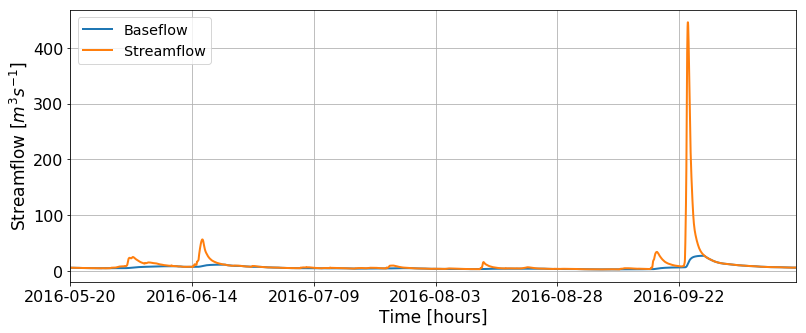

In [63]:
fi = '2016-5-20'
ff = '2016-10-15'
td = pd.Timedelta('3M')

fig = pl.figure(figsize=(13,5))
ax = fig.add_subplot(111)
ax.plot(Qsep[fi:ff].index, Qsep['Baseflow'][fi:ff].values, lw = 2, label = 'Baseflow')
ax.plot(Qobs[fi:ff].index, Qobs[fi:ff].values, lw = 2, label = 'Streamflow')
#ax.plot(Qsim[fi:ff].index, Qsim[fi:ff].values, lw = 2, label = 'HLM')
ax.tick_params(labelsize = 16)
ax.grid()
ax.set_xlabel('Time [hours]', size = 17)
ax.legend(loc = 0, fontsize = 'x-large')
ax.set_ylabel('Streamflow [$m^3s^{-1}$]', size = 17)
ax.set_xlim(Qsep[fi:ff].index[0], Qsep[fi:ff].index[-1])
ax.set_xticks(Qsep[fi:ff].index[::600])
Dates = Qsep[fi:ff].index[::600].to_pydatetime()
Dates = [i.strftime('%Y-%m-%d') for i in Dates]
ax.set_xticklabels(Dates)
#pl.savefig('../Results/BaseflowSep_example.png', bbox_inches = 'tight')

In [38]:
#pre process data in order to make the analysis.
Qobs, Qsim, Qsep = rc.Do_The_Separation(Qobs, Qsim)
Area, pos1, pos2 = rc.Do_The_FindEvents(Qobs, Qsim, linkID, minTime=1, minConcav=3)

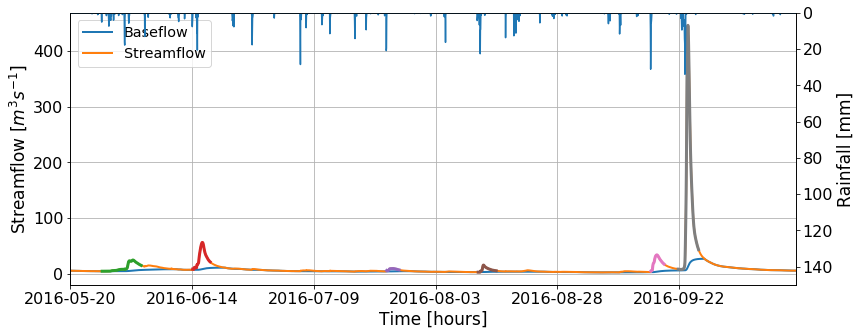

In [61]:
fi = '2016-5-20'
ff = '2016-10-15'
td = pd.Timedelta('1d')

fig = pl.figure(figsize=(13,5))
ax = fig.add_subplot(111)
ax.plot(Qsep[fi:ff].index, Qsep['Baseflow'][fi:ff].values, lw = 2, label = 'Baseflow')
ax.plot(Qobs[fi:ff].index, Qobs[fi:ff].values, lw = 2, label = 'Streamflow')

for p1, p2 in zip(pos1[(pos1>fi) & (pos1<ff)], pos2[(pos2>fi) & (pos2<ff)]):
    ax.plot(Qobs[p1:p2+td].index, Qobs[p1:p2+td].values, lw = 3)


ax.tick_params(labelsize = 16)
ax.grid()
ax.set_xlabel('Time [hours]', size = 17)
ax.legend(loc = 0, fontsize = 'x-large')
ax.set_ylabel('Streamflow [$m^3s^{-1}$]', size = 17)
ax.set_xlim(Qsep[fi:ff].index[0], Qsep[fi:ff].index[-1])
ax.set_xticks(Qsep[fi:ff].index[::600])
Dates = Qsep[fi:ff].index[::600].to_pydatetime()
Dates = [i.strftime('%Y-%m-%d') for i in Dates]
ax.set_xticklabels(Dates)

ax2=ax.twinx()
ax2AX=pl.gca()
ylim = ax2AX.get_ylim()[::-1]
ylim = (150, 0)
ax2AX.set_ylim(ylim)
ax2.plot(Rain[fi:ff].index, Rain[fi:ff].values)
ax2.set_ylabel('Rainfall [mm]', size = 17)
ax2.tick_params(labelsize = 16)
ax2.set_xticks(Qsep[fi:ff].index[::600])
ax2.set_xticklabels(Dates)
pl.savefig('../Results/EventSelect_example.png', bbox_inches = 'tight')

In [42]:
ylim

(1.0, 0.0)